# Sentiment Analysis
## TextCNN Model on Appliances dataset

## Importing Libraries

In [66]:
import pandas as pd
from pathlib import Path
import json
import csv

In [67]:
%matplotlib inline
import re
import seaborn as sbn
import nltk
import tqdm as tqdm
import sqlite3
import pandas as pd
import numpy as np

import string
from nltk.corpus import stopwords
stop = stopwords.words("english")
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from math import floor,ceil
from nltk.stem.porter import PorterStemmer
english_stemmer=nltk.stem.SnowballStemmer('english')

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

from sklearn.svm import LinearSVC

from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding


#from gensim import summarization
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

## Fetching the dataset (Prime Pantry)

In [68]:
df = pd.read_json (r'C:\Users\Neha Sharma\Desktop\Data Mining_project\Prime_Pantry.json', lines=True)
df.to_csv (r'C:\Users\Neha Sharma\Desktop\Data Mining_project\Prime_Pantry.csv', index = None)

In [69]:
#Making Dataframe
review_df = pd.read_csv(r'C:\Users\Neha Sharma\Desktop\Data Mining_project\Prime_Pantry.csv')
review_df

C:\Users\Neha Sharma\AppData\Local\Temp\ipykernel_7828\167545687.py:2: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  review_df = pd.read_csv(r'C:\Users\Neha Sharma\Desktop\Data Mining_project\Prime_Pantry.csv')


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style
0,5,True,"12 14, 2014",A1NKJW0TNRVS7O,B0000DIWNZ,Tamara M.,Good clinging,Clings well,1418515200,NaN,NaN,NaN
1,4,True,"11 20, 2014",A2L6X37E8TFTCC,B0000DIWNZ,Amazon Customer,Fantastic buy and a good plastic wrap. Even t...,Saran could use more Plus to Cling better.,1416441600,NaN,NaN,NaN
2,4,True,"10 11, 2014",A2WPR4W6V48121,B0000DIWNZ,noname,ok,Four Stars,1412985600,NaN,NaN,NaN
3,3,False,"09 1, 2014",A27EE7X7L29UMU,B0000DIWNZ,ZapNZs,Saran Cling Plus is kind of like most of the C...,"The wrap is fantastic, but the dispensing, cut...",1409529600,4.0,NaN,NaN
4,4,True,"08 10, 2014",A1OWT4YZGB5GV9,B0000DIWNZ,Amy Rogers,This is my go to plastic wrap so there isn't m...,has been doing it's job for years,1407628800,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
471609,5,True,"05 16, 2017",A19GSVHXVT5NNF,B01HI8JVI8,Mary Bright,Easy and delicious! I am usually a make-my-own...,Easy and delicious,1494892800,NaN,NaN,NaN
471610,5,True,"05 3, 2017",ABSCTKLX9F9IU,B01HI8JVI8,Lisa and Eric,Our elderly neighbor loves this and eats it on...,Salsa,1493769600,NaN,NaN,NaN
471611,5,False,"04 20, 2017",A2R33RCWKDHZ3L,B01HI8JVI8,Elle S.,"Great product, great price.",Five Stars,1492646400,NaN,NaN,NaN
471612,5,True,"04 19, 2017",A2INGHYEXZDHMC,B01HI8JVI8,Shelina is Platinum!,Great size value for the price! Salsa is chunk...,Five Stars,1492560000,NaN,NaN,NaN


In [74]:
#Coulmns in dataset
review_df.columns

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'image', 'style'],
      dtype='object')

## Data Cleaning

In [75]:
#Dropping the columns not required
review_df=review_df.drop(['vote','verified','reviewTime','style','reviewerName', 'unixReviewTime', 'image'],axis=1)

In [77]:
type(review_df['reviewText'][0])

str

<AxesSubplot: xlabel='overall', ylabel='count'>

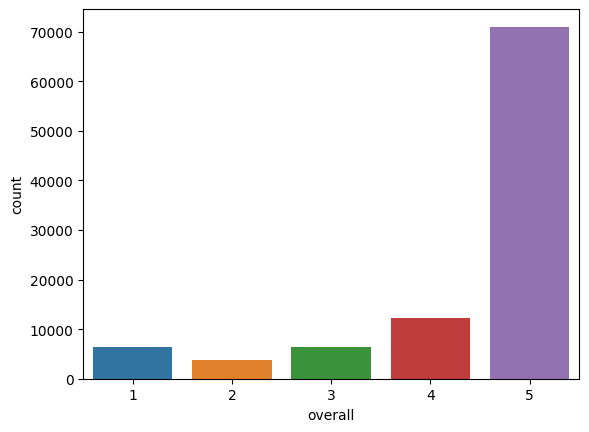

In [78]:
#Count of overall rating
sbn.countplot(x=review_df['overall'])

In [79]:
#Removing Stopwords
def data_clean( rev, remove_stopwords=True): 
    

    new_text = re.sub("[^a-zA-Z]"," ", rev)
   
    words = new_text.lower().split()
    
    if remove_stopwords:
        sts = set(stopwords.words("english"))
        words = [w for w in words if not w in sts]
    ary=[]
    eng_stemmer = english_stemmer 
    for word in words:
        ary.append(eng_stemmer.stem(word))

    
    return(ary)

In [80]:
cleaned_reviewData = []
for rev in review_df['reviewText']:
    #print(rev)
    cleaned_reviewData.append(" ".join(data_clean(str(rev))))
    
clean_summaryData = []
for rev in review_df['summary']:
    clean_summaryData.append(" ".join(data_clean(str(rev))))

In [81]:
#Fetching most frequent words from Review Text
Most_used_Words_Review =pd.Series(' '.join(cleaned_reviewData).lower().split()).value_counts()[:20]
print (Most_used_Words_Review)

great      23538
good       22937
use        21003
love       19142
like       18912
product    18529
tast       16567
one        10910
get         9948
price       9926
buy         9397
work        9078
flavor      8427
time        8227
make        8080
teeth       7699
tri         7648
realli      7553
would       6976
well        6919
dtype: int64


In [82]:
#Fetching most frequent words from Review Summary
Most_used_Words_Summary = pd.Series(' '.join(clean_summaryData).lower().split()).value_counts()[:20]
print (Most_used_Words_Summary)

star       34293
five       25799
great       9950
good        7744
love        5205
four        4098
product     4040
tast        3342
best        3034
like        2662
one         2265
work        2186
price       2085
three       1954
use         1575
delici      1570
smell       1463
buy         1308
flavor      1256
favorit     1222
dtype: int64


## Data Classification and Clustering

In [83]:
#preparing matrix of TF-IDF features
from sklearn.feature_extraction.text import TfidfVectorizer
text_vectorizer = TfidfVectorizer(min_df=4, max_features = 1000)
test_vecor = text_vectorizer.fit_transform(cleaned_reviewData)
tfidf_vector = dict(zip(text_vectorizer.get_feature_names_out(), text_vectorizer.idf_))

In [84]:
import nltk
nltk.downloader.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\Neha
[nltk_data]     Sharma\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [85]:
# Sentiment Analyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
sample_review = review_df.reviewText[:10]
for test in sample_review:
    test
    ss = analyser.polarity_scores(test)
    for k in sorted(ss):
        print('{0}: {1}, '.format(k, ss[k]))
    print(test)

compound: 0.4404, 
neg: 0.0, 
neu: 0.256, 
pos: 0.744, 
Good clinging
compound: 0.802, 
neg: 0.0, 
neu: 0.823, 
pos: 0.177, 
Fantastic buy and a good plastic wrap.  Even though labeled "Cling Plus," I feel that another plastic wrap holds and clings tighter for me.
Still, for the price and roll size, I'll order this product as needed with my Amazon Prime food orders.
compound: 0.296, 
neg: 0.0, 
neu: 0.0, 
pos: 1.0, 
ok
compound: 0.2743, 
neg: 0.133, 
neu: 0.734, 
pos: 0.133, 
Saran Cling Plus is kind of like most of the Cling Wrap from Glad. It is a very good quality plastic wrap, but the delivery system is poorly executed, and this makes usage more frustrating and less time-efficient. As convenience is one of the core selling points of this sort of product, how easy it is to use is just as important as how good the wrap itself is.

As another user here noted, getting this stuff out of the box and tearing off the portion you need to use is very difficult. Substantial force is required 

In [86]:
#Kmeans clusters
from sklearn.cluster import MiniBatchKMeans

clusters = 20
kmeans_model = MiniBatchKMeans(n_clusters=clusters, init='k-means++', n_init=1, 
                         init_size=1000, batch_size=1000, verbose=False, max_iter=1000)
kmodel = kmeans_model.fit(test_vecor)
kmodel_clusters = kmodel.predict(test_vecor)
kmodel_distances = kmodel.transform(test_vecor)
centroids = kmodel.cluster_centers_.argsort()[:, ::-1]
values = text_vectorizer.get_feature_names_out()
for i in range(clusters):
    print("Cluster %d:" % i)
    for j in centroids[i, :5]:
        print(' %s' % values[j])
    print()

Cluster 0:
 love
 smell
 kid
 great
 stuff

Cluster 1:
 nice
 smell
 clean
 product
 good

Cluster 2:
 tea
 green
 unsweeten
 tast
 best

Cluster 3:
 rice
 brown
 cook
 love
 good

Cluster 4:
 thank
 great
 good
 much
 product

Cluster 5:
 good
 great
 tast
 fresh
 product

Cluster 6:
 best
 favorit
 nut
 order
 box

Cluster 7:
 product
 great
 price
 love
 like

Cluster 8:
 good
 product
 price
 tast
 stuff

Cluster 9:
 great
 water
 flavor
 size
 work

Cluster 10:
 love
 product
 great
 tast
 good

Cluster 11:
 love
 zevia
 fit
 formula
 form

Cluster 12:
 smell
 wonder
 clean
 great
 product

Cluster 13:
 great
 price
 product
 tast
 work

Cluster 14:
 okay
 salti
 littl
 tast
 order

Cluster 15:
 excel
 product
 price
 great
 tast

Cluster 16:
 delici
 alway
 fresh
 healthi
 love

Cluster 17:
 like
 use
 tast
 work
 product

Cluster 18:
 tasti
 expect
 ok
 perfect
 yum

Cluster 19:
 yummi
 good
 great
 fresh
 fast



In [87]:
test_reviewText = review_df.reviewText
test_Ratings = review_df.overall
text_vectorizer = TfidfVectorizer(max_df=.8)
text_vectorizer.fit_transform(test_reviewText.values.astype('U'))
#v.fit_transform(df['Review'].values.astype('U')) 
def rate(r):
    ary2 = []
    for rating in r:
        tv = [0,0,0,0,0]
        tv[rating-1] = 1
        ary2.append(tv)
    return np.array(ary2)

In [88]:
#Review text
test_reviewText =test_reviewText[:2000]
test_reviewText

0                                           Good clinging
1       Fantastic buy and a good plastic wrap.  Even t...
2                                                      ok
3       Saran Cling Plus is kind of like most of the C...
4       This is my go to plastic wrap so there isn't m...
                              ...                        
1995    For my wife and I this milk is nearly indispen...
1996                                  Not what I expected
1997    I've tried many of the Jalepeno chips, these g...
1998    These are my favorite potato chips. Nice and c...
1999    All the bags had stale chips. Our money was re...
Name: reviewText, Length: 2000, dtype: object

In [89]:
#Overall ratings
test_Ratings = test_Ratings[:2000]
test_Ratings

0       5
1       4
2       4
3       3
4       4
       ..
1995    3
1996    3
1997    5
1998    5
1999    3
Name: overall, Length: 2000, dtype: int64

In [90]:
X = text_vectorizer.transform(test_reviewText.values.astype('U')).toarray()
y = rate(test_Ratings.values)

## TextCNN Model

In [91]:
#TextCNN Model
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.1)

#After performing Oversampling (because of high amount of data in with 5 Rating)
over = SMOTE(k_neighbors=3)
X_train, y_train = over.fit_resample(X_train, y_train)

#model implementation
model = Sequential()
model.add(Dense(128,input_dim=X_train.shape[1]))
model.add(Dense(5,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
map=model.fit(X_train,y_train,validation_data=(X_test, y_test),epochs=10,batch_size=32,verbose=1)
model.evaluate(X_test,y_test)[1]

Epoch 1/10
57/57 [==============================] - 7s 92ms/step - loss: 1.1857 - accuracy: 0.6556 - val_loss: 1.0431 - val_accuracy: 0.6550
Epoch 2/10
57/57 [==============================] - 4s 77ms/step - loss: 0.9243 - accuracy: 0.6639 - val_loss: 0.9320 - val_accuracy: 0.6750
Epoch 3/10
57/57 [==============================] - 5s 83ms/step - loss: 0.7998 - accuracy: 0.6933 - val_loss: 0.8664 - val_accuracy: 0.7000
Epoch 4/10
57/57 [==============================] - 4s 78ms/step - loss: 0.7034 - accuracy: 0.7306 - val_loss: 0.8236 - val_accuracy: 0.7300
Epoch 5/10
57/57 [==============================] - 4s 79ms/step - loss: 0.6253 - accuracy: 0.7622 - val_loss: 0.8036 - val_accuracy: 0.7300
Epoch 6/10
57/57 [==============================] - 5s 79ms/step - loss: 0.5564 - accuracy: 0.7972 - val_loss: 0.7932 - val_accuracy: 0.7450
Epoch 7/10
57/57 [==============================] - 4s 79ms/step - loss: 0.4933 - accuracy: 0.8378 - val_loss: 0.7996 - val_accuracy: 0.7400
Epoch 8/10
57

0.7149999737739563

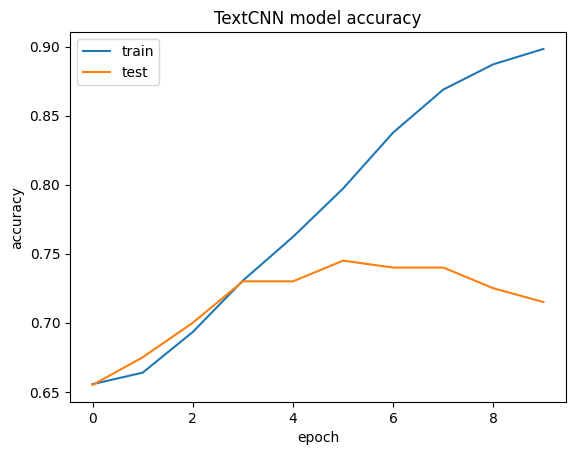

In [92]:
#TextCNN model accuracy graph
plt.plot(map.history['accuracy'])
plt.plot(map.history['val_accuracy'])
plt.title('TextCNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

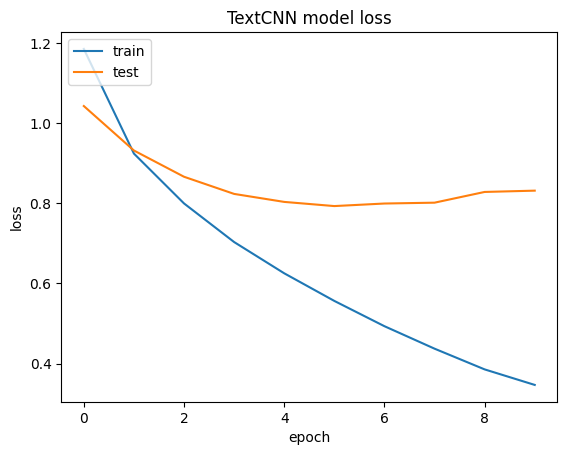

In [93]:
#TextCNN model Loss graph
plt.plot(map.history['loss'])
plt.plot(map.history['val_loss'])
plt.title('TextCNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()